In [1]:
import pandas as pd
import numpy as np
import random as rand
import tqdm
import networkx as nx
import pickle as pkl
import gower
import matplotlib.pyplot as plt
import methods
from methods import topK, findGroups, prototype, ranking, getAttributes, Q, Q2, Discovery

In [2]:
from torch_geometric.datasets import WebKB

# Load the Tolokers dataset
dataset = WebKB(root='./data/GNNBenchmarkDataset', name='Cornell')

# Access the first graph in the dataset
data = dataset[0]

# Print basic information about the dataset
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature matrix shape: {data.x.shape}")  # Node features
print(f"Number of classes: {data.y.unique().size(0)}")  # Number of distinct classes
print(f"First node's features: {data.x[0]}")


Number of nodes: 183
Number of edges: 298
Node feature matrix shape: torch.Size([183, 1703])
Number of classes: 5
First node's features: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [3]:
# Custom wrapper to simulate GraphPropPredDataset structure
class CustomGraphDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        # Extract a graph from the dataset
        graph_data = self.dataset[idx]
        
        # Convert to the desired dictionary format similar to GraphPropPredDataset
        graph = {
            'edge_index': graph_data.edge_index,  # Edge index
            'num_nodes': graph_data.num_nodes,  # Number of nodes
            'node_feat': graph_data.x  # Node features (if available)
        }
        
        label = graph_data.y
        return graph, label

    def __len__(self):
        return len(self.dataset)

# Instantiate the custom dataset
custom_dataset = CustomGraphDataset(dataset)
graph, label = custom_dataset[0]



In [4]:

# Access edge index, number of nodes, and node features
edge_index = graph['edge_index']
num_nodes = graph['num_nodes']
edge_index = data.edge_index 
num_nodes = data.num_nodes 
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))  # Convert tensor to list of tuples
G.add_edges_from(edges)

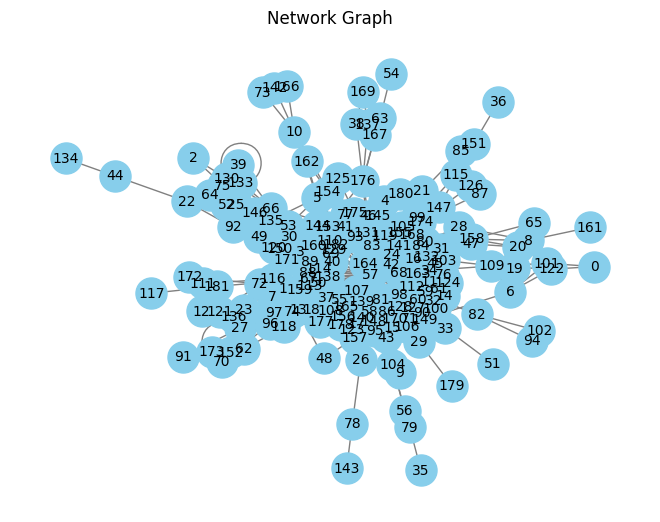

In [5]:
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Network Graph")
plt.show()

In [6]:
academic_classes = [0, 1, 2]  # Student, Professor, Course so (False = project/staff)
binary_target = data.y.apply_(lambda x: 1 if x in academic_classes else 0)
binary_target

tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [7]:
attributes = graph['node_feat']
lu = pd.DataFrame(attributes)
lu['target'] = binary_target == 1 # this 
lu.head()

,0,1,2,3,4,5,6,7,8,9,...,1694,1695,1696,1697,1698,1699,1700,1701,1702,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [8]:
result = findGroups(G, 20, lu)
result 

100%|██████████| 183/183 [02:53<00:00,  1.05it/s]


,rho,sigma,q,ranks,reference,subgroup
78,21,6,0.254535,"[(78, True), (26, False), (143, True), (57, Tr...","[78, 26, 143, 57, 170, 59, 119, 14, 168, 18, 5...","[78, 26, 143, 57, 170, 59]"
135,36,10,0.251811,"[(135, True), (64, True), (5, False), (57, Tru...","[135, 64, 5, 57, 22, 103, 110, 18, 45, 59, 92,...","[135, 64, 5, 57, 22, 103, 110, 18, 45, 59]"
30,39,6,0.246402,"[(30, False), (25, True), (67, True), (146, Tr...","[30, 25, 67, 146, 57, 66, 110, 13, 144, 174, 1...","[30, 25, 67, 146, 57, 66]"
60,22,4,0.242274,"[(60, True), (57, True), (119, False), (59, Tr...","[60, 57, 119, 59, 168, 18, 132, 174, 157, 131,...","[60, 57, 119, 59]"
16,33,3,0.228418,"[(16, True), (57, True), (59, True), (14, Fals...","[16, 57, 59, 14, 98, 119, 18, 45, 157, 168, 12...","[16, 57, 59]"
164,35,5,0.226779,"[(164, False), (57, True), (42, True), (138, T...","[164, 57, 42, 138, 83, 174, 129, 69, 119, 18, ...","[164, 57, 42, 138, 83]"
165,36,5,0.225677,"[(165, False), (149, True), (67, True), (97, T...","[165, 149, 67, 97, 57, 174, 110, 119, 144, 157...","[165, 149, 67, 97, 57]"
19,35,5,0.215980,"[(19, False), (103, True), (57, True), (83, Tr...","[19, 103, 57, 83, 59, 129, 119, 157, 174, 69, ...","[19, 103, 57, 83, 59]"
113,34,3,0.209678,"[(113, True), (57, True), (60, True), (119, Fa...","[113, 57, 60, 119, 59, 168, 40, 157, 174, 18, ...","[113, 57, 60]"
59,19,3,0.202165,"[(59, True), (57, True), (119, False), (168, F...","[59, 57, 119, 168, 18, 131, 170, 98, 157, 174,...","[59, 57, 119]"


In [10]:
result.to_csv('subgroups_cornell.csv')